# The Rick and Morty API

In [17]:
# Import libraries
import pandas as pd
import requests
import json
import datetime

# S3 imports
import boto3

In [2]:
# Fetch character data from api
url = "https://rickandmortyapi.com/api/episode"

response = requests.get(url)
data = response.json()

print(data.keys())

dict_keys(['info', 'results'])


In [3]:
# Analyze the info key
data['info']

{'count': 51,
 'pages': 3,
 'next': 'https://rickandmortyapi.com/api/episode?page=2',
 'prev': None}

In [4]:
# Analyze the result key
print(len(data['results']))
data['results'][0]

20


{'id': 1,
 'name': 'Pilot',
 'air_date': 'December 2, 2013',
 'episode': 'S01E01',
 'characters': ['https://rickandmortyapi.com/api/character/1',
  'https://rickandmortyapi.com/api/character/2',
  'https://rickandmortyapi.com/api/character/35',
  'https://rickandmortyapi.com/api/character/38',
  'https://rickandmortyapi.com/api/character/62',
  'https://rickandmortyapi.com/api/character/92',
  'https://rickandmortyapi.com/api/character/127',
  'https://rickandmortyapi.com/api/character/144',
  'https://rickandmortyapi.com/api/character/158',
  'https://rickandmortyapi.com/api/character/175',
  'https://rickandmortyapi.com/api/character/179',
  'https://rickandmortyapi.com/api/character/181',
  'https://rickandmortyapi.com/api/character/239',
  'https://rickandmortyapi.com/api/character/249',
  'https://rickandmortyapi.com/api/character/271',
  'https://rickandmortyapi.com/api/character/338',
  'https://rickandmortyapi.com/api/character/394',
  'https://rickandmortyapi.com/api/character

In [7]:
# Function to write data to a dataframe
from tqdm import tqdm
import time

all_data = []
page = 1

# Initialize the progress bar
with tqdm(desc="Extracting Pages", ncols=100, ascii=True) as pbar:
    while True:
        # Update the progress bar description with the current page
        pbar.set_description(f"Extracting Page {page}")
        
        # Make the API request
        response = requests.get(f'https://rickandmortyapi.com/api/episode?page={str(page)}')
        data = response.json().get('results', [])
        
        # Collect data
        all_data.extend(data)
        
        # Update the progress bar (increment by 1 page)
        pbar.update(1)
        
        # Check if there is a next page
        if response.json().get('info', {}).get('next') is not None:
            page += 1
        else:
            break

    print('Data successfully extracted!')

Extracting Page 3: : 3it [00:02,  1.49it/s]

Data successfully extracted!


In [8]:
# Load data to dataframe
episodes_df = pd.DataFrame(all_data)

# Shape of df
print(episodes_df.shape)

# Ivestigate the dataframe
episodes_df.head()

(51, 7)


,id,name,air_date,episode,characters,url,created
0,1,Pilot,"December 2, 2013",S01E01,"[https://rickandmortyapi.com/api/character/1, ...",https://rickandmortyapi.com/api/episode/1,2017-11-10T12:56:33.798Z
1,2,Lawnmower Dog,"December 9, 2013",S01E02,"[https://rickandmortyapi.com/api/character/1, ...",https://rickandmortyapi.com/api/episode/2,2017-11-10T12:56:33.916Z
2,3,Anatomy Park,"December 16, 2013",S01E03,"[https://rickandmortyapi.com/api/character/1, ...",https://rickandmortyapi.com/api/episode/3,2017-11-10T12:56:34.022Z
3,4,M. Night Shaym-Aliens!,"January 13, 2014",S01E04,"[https://rickandmortyapi.com/api/character/1, ...",https://rickandmortyapi.com/api/episode/4,2017-11-10T12:56:34.129Z
4,5,Meeseeks and Destroy,"January 20, 2014",S01E05,"[https://rickandmortyapi.com/api/character/1, ...",https://rickandmortyapi.com/api/episode/5,2017-11-10T12:56:34.236Z


## Data Cleaning

In [11]:
# Clean the origin column
import re

# Function to extract the last digit (resident id) from each URL
def extract_character_ids(character_list):
    if character_list:
        return [re.search(r'/(\d+)$', url).group(1) for url in character_list if re.search(r'/(\d+)$', url)]
    return []

# Apply the function to the episodes column
episodes_df['character_ids'] = episodes_df['characters'].apply(extract_character_ids)
episodes_df['total_characters'] = episodes_df['character_ids'].apply(len)

# Drop origin and location columns
episodes_df = episodes_df.drop('characters', axis=1)

episodes_df.head()

,id,name,air_date,episode,url,created,character_ids,total_characters
0,1,Pilot,"December 2, 2013",S01E01,https://rickandmortyapi.com/api/episode/1,2017-11-10T12:56:33.798Z,"[1, 2, 35, 38, 62, 92, 127, 144, 158, 175, 179...",19
1,2,Lawnmower Dog,"December 9, 2013",S01E02,https://rickandmortyapi.com/api/episode/2,2017-11-10T12:56:33.916Z,"[1, 2, 38, 46, 63, 80, 175, 221, 239, 246, 304...",19
2,3,Anatomy Park,"December 16, 2013",S01E03,https://rickandmortyapi.com/api/episode/3,2017-11-10T12:56:34.022Z,"[1, 2, 12, 17, 38, 45, 96, 97, 98, 99, 100, 10...",24
3,4,M. Night Shaym-Aliens!,"January 13, 2014",S01E04,https://rickandmortyapi.com/api/episode/4,2017-11-10T12:56:34.129Z,"[1, 2, 38, 87, 175, 179, 181, 191, 239, 241, 2...",13
4,5,Meeseeks and Destroy,"January 20, 2014",S01E05,https://rickandmortyapi.com/api/episode/5,2017-11-10T12:56:34.236Z,"[1, 2, 38, 41, 89, 116, 117, 120, 175, 193, 23...",20


In [12]:
# Reorder columns
episodes_df = episodes_df[episodes_df.columns[[0, 1, 2, 3, 6, 7, 5, 4]]]

episodes_df.head()

,id,name,air_date,episode,character_ids,total_characters,created,url
0,1,Pilot,"December 2, 2013",S01E01,"[1, 2, 35, 38, 62, 92, 127, 144, 158, 175, 179...",19,2017-11-10T12:56:33.798Z,https://rickandmortyapi.com/api/episode/1
1,2,Lawnmower Dog,"December 9, 2013",S01E02,"[1, 2, 38, 46, 63, 80, 175, 221, 239, 246, 304...",19,2017-11-10T12:56:33.916Z,https://rickandmortyapi.com/api/episode/2
2,3,Anatomy Park,"December 16, 2013",S01E03,"[1, 2, 12, 17, 38, 45, 96, 97, 98, 99, 100, 10...",24,2017-11-10T12:56:34.022Z,https://rickandmortyapi.com/api/episode/3
3,4,M. Night Shaym-Aliens!,"January 13, 2014",S01E04,"[1, 2, 38, 87, 175, 179, 181, 191, 239, 241, 2...",13,2017-11-10T12:56:34.129Z,https://rickandmortyapi.com/api/episode/4
4,5,Meeseeks and Destroy,"January 20, 2014",S01E05,"[1, 2, 38, 41, 89, 116, 117, 120, 175, 193, 23...",20,2017-11-10T12:56:34.236Z,https://rickandmortyapi.com/api/episode/5


## EDA - Exploratory Data Analysis

In [13]:
# import visulaization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# Location type value count
type_of_loc = location_df['type'].value_counts().head(4)
type_of_loc

Planet           62
Space station     7
Dimension         4
Microverse        3
Name: type, dtype: int64

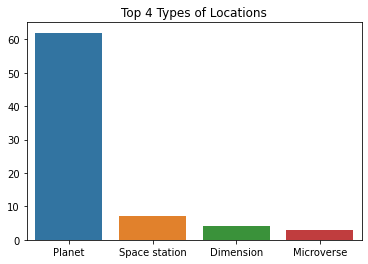

In [32]:
# Plot a bar plot showing the status
ax = sns.barplot(x=type_of_loc.index, y=type_of_loc.values)

# Set the xtick labels
ax.set_xticklabels(type_of_loc.index)
ax.set_title('Top 4 Types of Locations');

### Top 10 charcater episode appearances

In [16]:
# Sort the DataFrame by 'total_episodes' in descending order
sorted_df = episodes_df.sort_values(by='total_characters', ascending=False)

# Select the top 10 characters
top_10 = sorted_df.head(10)

# Display the result
top_10[['episode', 'total_characters']]


,episode,total_characters
27,S03E07,65
9,S01E10,60
7,S01E08,57
36,S04E06,49
21,S03E01,44
50,S05E10,42
18,S02E08,40
31,S04E01,38
42,S05E02,37
12,S02E02,36
